In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from scipy import interpolate, signal
%matplotlib inline

In [2]:
fdir = "D:/crs/proj/2019_DorianOBX/WayneWright_flights/"

fnames = (\
          "post_Matthew_lidar_1m.tif",\
          "2019-08-30_1m_DEM_v1.tif",\
          "2019-09-12-13_DEM_1m_v1.tif")

titles = ([\
         "post-Matthew",\
         "pre-Dorian",\
         "post-Dorian"])


In [3]:
def box2UTMh(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        xr, yr - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),\
                   (0., 1., y0),\
                   (0., 0., 1.)))
    
    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    xr = xyrh[0,:]
    yr = xyrh[1,:]
    return xr, yr

In [11]:
# make a small box w/ cell centered grid with spacing dxy
dxy = 1.
xmax = 1800. # alongshore
ymax = 500.  # cross-shore
nx = int((1./dxy)*xmax)
ny = int((1./dxy)*ymax)

# kernal size for smoothing original map...this should be an odd number >= dxy/0.1
ksize = 3 
xcoords = np.linspace(0.5*dxy,xmax-0.5*dxy,nx)
ycoords = np.linspace(0.5*dxy,ymax-0.5*dxy,ny)
# Y is ascending
xrot, yrot=np.meshgrid(xcoords, ycoords ,sparse=False, indexing='xy')
print("xrot:")
print(xrot.shape)
print(xrot)
print("yrot:")
print(yrot.shape)
print(yrot)

xrot:
(500, 1800)
[[5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 ...
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]]
yrot:
(500, 1800)
[[  0.5   0.5   0.5 ...   0.5   0.5   0.5]
 [  1.5   1.5   1.5 ...   1.5   1.5   1.5]
 [  2.5   2.5   2.5 ...   2.5   2.5   2.5]
 ...
 [497.5 497.5 497.5 ... 497.5 497.5 497.5]
 [498.5 498.5 498.5 ... 498.5 498.5 498.5]
 [499.5 499.5 499.5 ... 499.5 499.5 499.5]]


In [12]:
# Define the ROI with bottom left corner and rotation of axes
#e0 = 391210.; n0 = 3868600.
e0 = 391460.; n0 = 3868410.

rot = 43.

print('Shape of xrot, yrot: ',np.shape(xrot),np.shape(xrot))
shp = np.shape(xrot)
xu, yu = box2UTMh(xrot.flatten(), yrot.flatten(), e0, n0, rot)
xu=np.reshape(xu,shp)
yu=np.reshape(yu,shp)
print('Shape of xu and yu: ',np.shape(xu),np.shape(yu))

Shape of xrot, yrot:  (500, 1800) (500, 1800)
Shape of xu and yu:  (500, 1800) (500, 1800)


In [ ]:
# check rotations using lidar DEM
fn = fdir+fnames[0]
da = xr.open_rasterio(fn)
plt.imshow(np.squeeze(da))


In [ ]:
%%time
nf = 3
dslist=[]
for i in range(nf):
    fn = fdir+fnames[i]
    print(i, fn)
    
    # open the tif with XArray as a DataArray
    da = xr.open_rasterio(fn)
    
    print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
    x = da['x'].values
    y = np.flipud(da['y'].values)
    
    # Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
    # However, make sure to squeeze before flipping
    z = np.flipud(np.squeeze(da.values))
    print(np.shape(x),np.shape(y),np.shape(z))
    

    # smooth with 2D running median
    zs = signal.medfilt2d(z, kernel_size=ksize)
    
    f = interpolate.RegularGridInterpolator( (y, x), zs, method='linear')   
    
    # Array for interpolated elevations
    zi=np.NaN*np.ones((ny,nx))

    # this is a slow iteration through all of the points, but allows us to skip ones that are outside
    for ij in np.ndindex(zi.shape):
        try:
            zi[ij]=f((yu[ij],xu[ij]))
        except:
            zi[ij]=np.NaN
            
    da = xr.DataArray(zi,dims=['Alongshore','Cross-shore'],coords={'Alongshore': ycoords, 'Cross-shore':xcoords })
    # dslist.append(da.chunk()) # this does not work...can't concatenate a method
    da = da.chunk()
    dslist.append(da)

dsa = xr.concat(dslist, dim='map')
dsa

0 D:/crs/proj/2019_DorianOBX/WayneWright_flights/post_Matthew_lidar_1m.tif
(34727,) (38113,) (1, 34727, 38113)
(38113,) (34727,) (34727, 38113)


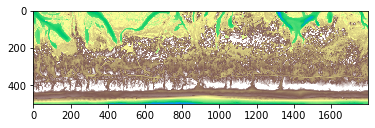

In [14]:
plt.imshow(np.flipud(dsa[0,:,:]),cmap=plt.cm.terrain,vmin=-2,vmax=3.5)